In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

In [7]:
import datetime

In [8]:
import scipy.optimize
import pandas.io.sql as psql
import pandas as pd
import sys
sys.path.insert(0,'C:\Users\Sean Violante\Documents\Projects\lendico\lib')
import dwh

In [403]:
%load_ext autoreload

In [404]:
%aimport dwh


In [405]:
%autoreload 1

In [38]:
%matplotlib qt

In [413]:
%cd C:/Users/Sean Violante/Documents/Projects/lendico/lib

C:\Users\Sean Violante\Documents\Projects\lendico\lib


In [415]:
%run 'dwh.py'

In [9]:
conn = dwh.get_DWH()

In [5]:
type(conn)

sqlalchemy.engine.base.Engine

In [10]:
test_sql='select distinct fk_loan from base.de_payments'

In [12]:
test.shape

(1540, 1)

In [11]:
test=psql.read_sql(test_sql,conn)

In [400]:
payment_plans_combined_sql="""SELECT pp.dwh_country_id, pp.fk_loan, pp.fk_loan_request,l.loan_nr as loan_request_nr, 
        pp.fk_user_investor, pp.fk_user_borrower, pp.country_name, 
        pp.nominal_interest_percentage, pp.promo_interest_percentage, pp.has_promo_flag, 
        pp.is_repaid_flag, 
        pp.payout_date, pp.interval, pp.interval_payback_date, pp.next_interval_payback_date, 
        pp.loan_coverage, 
    
        pp.payment_amount_borrower,
        sum(pp.payment_amount_borrower) OVER wind as payment_amount_borrower_cum,
        
        pp.principal_amount_borrower, 
        sum(pp.principal_amount_borrower) OVER wind as principal_amount_borrower_cum,
        
        pp.interest_amount_borrower,
        sum(pp.interest_amount_borrower) OVER wind as interest_amount_borrower_cum,
        
        pp.initial_principal_amount_borrower, 
        pp.residual_interest_amount_borrower, pp.residual_principal_amount_borrower, 
        
        pp.calc_service_fee, 
        
        pp.payment_amount_investor, 
        sum(pp.payment_amount_investor) OVER wind as payment_amount_investor_cum,
        
        pp.principal_amount_investor, 
        sum(pp.principal_amount_investor) OVER wind as principal_amount_investor_cum,
        
        pp.interest_amount_investor, 
        sum(pp.interest_amount_investor) OVER wind as interest_amount_investor_cum,
        
        pp.initial_principal_amount_investor, pp.sum_interval_interest_amount_investor, 
        pp.residual_interest_amount_investor, pp.residual_principal_amount_investor
    
        
        FROM base.loan_payment_plan_combined_item pp
        join base.loan l on (pp.dwh_country_id=l.dwh_country_id and pp.fk_loan=l.id_loan )
        join base.loan_funding lf on (pp.dwh_country_id=lf.dwh_country_id and pp.fk_loan=lf.fk_loan and pp.fk_user_investor=lf.fk_user)
        where pp.dwh_country_id=1 and l.state!='canceled' 
        and l.id_loan not in (3,4,6,8,11,14) and 
        lf.state='funded' and 
        pp.interval_payback_date<=current_date
        WINDOW wind as (PARTITION BY pp.dwh_country_id, pp.fk_loan, pp.fk_user_investor order by interval)
"""


In [16]:
payment_plans_sql='''select 
dwh_country_id, fk_loan_payment_plan, fk_user, fk_loan_request, fk_loan, country_name, currency_code, loan_request_creation_date, 
interval, payment_amount, interest_amount, principal_amount, interval_payback_date, next_interval_payback_date, 
initial_principal_amount, sum_interval_interest_amount, residual_interest_amount, residual_principal_amount
from base.loan_payment_plan_item where dwh_country_id=1 and fk_loan not in {}'''.format(excluded_loans)

In [11]:
excluded_loans=(3,4,6,8,11,14,526,528,558,630,557,556,555,553,552,554,578,579,580,603,596,611,642)
print(" hello {}".format(excluded_loans))

 hello (3, 4, 6, 8, 11, 14, 526, 528, 558, 630, 557, 556, 555, 553, 552, 554, 578, 579, 580, 603, 596, 611, 642)


In [12]:
loans_sql="""select l.*, gblrc.credit_agency_score, gblrc.pd, gblrc.pd_original, gblrc.lgd, gblrc.in_arrears_since, 
lp.state as payback_state
from base.loan l
join il.global_borrower_loan_requests_cohort gblrc
on (l.dwh_country_id=gblrc.dwh_country_id and l.loan_nr=gblrc.loan_request_nr)

join base.loan_payback lp
on (l.dwh_country_id=lp.dwh_country_id and l.id_loan=lp.fk_loan)
where 
    l.dwh_country_id=1 and 
    l.state!='canceled' and 
    id_loan not in {} and 
    originated_since is not null""".format(excluded_loans)
# 3,4,6,8,11,14 are test loans (from test users)

In [13]:
loan_fundings_sql="""select * from base.loan_funding where dwh_country_id=1 
and fk_loan not in {} and state='funded'""".format(excluded_loans)

In [17]:
%time payment_plans=psql.read_sql(payment_plans_sql,conn)

Wall time: 38.3 s


In [18]:
%time loans=psql.read_sql(loans_sql,conn)

Wall time: 7.46 s


In [48]:
loans.columns

Index([u'dwh_country_id', u'id_loan', u'fk_loan_request', u'fk_user', u'fk_ranking', u'country_name', u'currency_code', u'loan_request_creation_date', u'user_age', u'loan_nr', u'title', u'purpose', u'financial_situation', u'self_rating', u'rating', u'principal_amount', u'duration', u'nominal_interest_percentage', u'promo_interest_percentage', u'fee_amount', u'interest_amount', u'total_payback', u'is_active', u'category', u'ranking_serialized', u'state', u'global_state', u'originating_since', u'originated_since', u'due_date', u'funded_amount', u'ip_address', u'live_since', u'ranking_parameter', u'acc_account_id', u'date_of_signature', u'borrower_fee', u'lender_fee', u'data_accessible_by', u'date_of_payout', u'date_of_origination_complete', u'interest_calculation_method', u'initial_interest_split_strategy', u'effective_interest_percentage', u'cancel_reason', u'cancel_reason_comment', u'eur_principal_amount', u'eur_fee_amount', u'eur_interest_amount', u'eur_total_payback', u'created_at', 

In [54]:
payment_plans.columns

Index([u'dwh_country_id', u'fk_loan_payment_plan', u'fk_user', u'fk_loan_request', u'fk_loan', u'country_name', u'currency_code', u'loan_request_creation_date', u'interval', u'payment_amount', u'interest_amount', u'principal_amount', u'interval_payback_date', u'next_interval_payback_date', u'initial_principal_amount', u'sum_interval_interest_amount', u'residual_interest_amount', u'residual_principal_amount', u'recovery', u'pd'], dtype='object')

In [364]:
loan_fundings.columns

Index([u'dwh_country_id', u'id_loan_funding', u'fk_loan', u'fk_loan_request', u'fk_user', u'country_name', u'currency_code', u'loan_request_creation_date', u'amount', u'investment_yield', u'state', u'is_authorized', u'authorization_token', u'loan_request_funding_created_at', u'country', u'data_accessible_by', u'investment_fee', u'investment_return_state', u'payment_count', u'last_payment_date', u'irregular_payments', u'eur_amount', u'created_at', u'updated_at', u'dwh_created', u'dwh_last_modified'], dtype='object')

In [171]:
loan_fundings1=loan_fundings.merge(loans[['id_loan','principal_amount']],left_on=['fk_loan'],right_on=['id_loan'])

In [172]:
loan_fundings1['loan_coverage1']=loan_fundings1.amount/loan_fundings1.principal_amount*100

In [221]:
loans['originated_since_date']=0

In [19]:
loans['rating_base']=loans.rating.str[0]
loans['originated_since_date']=np.array(loans.originated_since,'datetime64[D]')
loans['rating_switch']=1 + \
    (loans['originated_since_date']>np.datetime64('2014-06-30')) + \
    (loans['originated_since_date']>np.datetime64('2014-10-14'))

In [231]:
loans.originated_since_date[loans['rating_switch']==3].head()

317   2014-10-23
394   2014-10-23
402   2014-10-29
403   2014-10-16
407   2014-12-03
Name: originated_since_date, dtype: datetime64[ns]

In [21]:
%time loan_fundings=psql.read_sql(loan_fundings_sql,conn)

Wall time: 32.7 s


In [401]:
%time payment_plans_combined=psql.read_sql(payment_plans_combined_sql,conn)

Wall time: 3min 48s


In [402]:
payment_plans_combined.shape

(168353, 36)

In [158]:
actual_payments_sql= """

 with 

actual_payments as (select 
dp.dwh_country_id, dp.fk_user as fk_user_borrower, dp.fk_loan, dp.loan_request_nr
 ,dp.iso_date 
 ,dp.expected_amount_cum, dp.actual_amount_cum, in_arrears_flag, dp.in_arrears_since
 ,in_arrears_since_days
 
,dp.expected_amount_cum - lag(expected_amount_cum,1,0.0) over ( partition by dp.dwh_country_id, dp.fk_loan  order by dp.iso_date)  expected_amount_month
,dp.actual_amount_cum - lag(actual_amount_cum,1,0.0) over ( partition by dp.dwh_country_id, dp.fk_loan order by iso_date)
 actual_amount_month
 from base.de_payments dp
 join base.loan_payback lp on (lp.dwh_country_id=dp.dwh_country_id and lp.fk_loan=dp.fk_loan) 


where dp.iso_date=(date_trunc('MONTH', dp.iso_date) + INTERVAL '1 MONTH - 1 day')::date
and (lp.state!='payback_complete' or dp.iso_date <=lp.last_payment_date)
and dp.fk_loan not in {0}
) ,


actual_payments_cum as (
select 
ap.dwh_country_id, ap.fk_loan, 
-- dp.iso_date as date,min(pp.interval) as interval, min(interval_payback_date) interval_payback_date--, dp.actual_amount_cum, pp.payment_amount_cum'
ap.iso_date,max(pp.interval) as interval

from actual_payments ap

join 
(select dwh_country_id, fk_loan, interval, interval_payback_date, sum(payment_amount) \
    OVER (partition by dwh_country_id,fk_loan order by interval) payment_amount_cum  
    from base.loan_payment_plan_item ) pp
on 
 (ap.dwh_country_id=pp.dwh_country_id and
 ap.fk_loan=pp.fk_loan and 
 -- ap.iso_date>=pp.interval_payback_date ??? IS THIS OK
 ap.actual_amount_cum>=pp.payment_amount_cum )
 

group by ap.dwh_country_id, ap.fk_loan,  ap.iso_date 
--order by date, interval

),


 paymentplan as
(

SELECT pp.dwh_country_id, pp.fk_user, pp.fk_loan_request,pp.fk_loan, l.loan_nr, pp.country_name, interval,
payment_amount, pp.interest_amount
,pp.principal_amount,interval_payback_date,next_interval_payback_date,initial_principal_amount,
sum_interval_interest_amount,residual_interest_amount,residual_principal_amount
, sum(coalesce(payment_amount,0) ) 
 OVER W::float as payment_amount_cum

 , sum(coalesce(pp.interest_amount,0) ) 
 OVER W::float as interest_amount_cum

 , sum(coalesce(pp.principal_amount,0) ) 
  OVER W::float as principal_amount_cum

        FROM base.loan_payment_plan_item pp 
        

 join   base.loan l    
 on     l.id_loan=pp.fk_loan and l.dwh_country_id=pp.dwh_country_id  
 
WINDOW W as (partition by pp.dwh_country_id, pp.fk_loan ORDER BY pp.interval_payback_date)
)

select 

 
 ap.dwh_country_id as dwh_country_id
 , ap.fk_user_borrower
 , ap.fk_loan as fk_loan
 , pp.loan_nr
 , ap.iso_date
 , pp.interval
 , pp.interval_payback_date
,pp.payment_amount, pp.payment_amount_cum,

pp.principal_amount, pp.interest_amount, pp.sum_interval_interest_amount, 
pp.interest_amount_cum,
pp.residual_interest_amount,
 pp.principal_amount_cum,
 pp.initial_principal_amount, 
coalesce (pp.residual_principal_amount, l.principal_amount) as residual_principal_amount

,expected_amount_month, expected_amount_cum
,actual_amount_month, actual_amount_cum
, in_arrears_flag, in_arrears_since
 ,in_arrears_since_days  



from actual_payments ap
left join actual_payments_cum ap_cum 
   on( 
  ap.dwh_country_id=ap_cum.dwh_country_id and 
  ap.fk_loan=ap_cum.fk_loan and 
  ap.iso_date=ap_cum.iso_date
   )
  
left join paymentplan pp
 
on (pp.dwh_country_id=ap.dwh_country_id and 
        pp.fk_loan=ap.fk_loan and 
        ap_cum.interval=pp.interval)
join base.loan l 
on (ap.dwh_country_id=l.dwh_country_id and ap.fk_loan=l.id_loan)
where  ap.dwh_country_id=1 and ap.iso_date <=current_date and  ap.fk_loan not in {0} 

order by dwh_country_id,fk_loan,iso_date ;
""".format(excluded_loans)


In [159]:
actual_payments=psql.read_sql(actual_payments_sql,conn)

In [49]:
actual_payments.columns

Index([u'dwh_country_id', u'fk_user_borrower', u'fk_loan', u'loan_nr', u'iso_date', u'interval', u'interval_payback_date', u'payment_amount', u'payment_amount_cum', u'principal_amount', u'interest_amount', u'sum_interval_interest_amount', u'interest_amount_cum', u'residual_interest_amount', u'principal_amount_cum', u'initial_principal_amount', u'residual_principal_amount', u'expected_amount_month', u'expected_amount_cum', u'actual_amount_month', u'actual_amount_cum', u'in_arrears_flag', u'in_arrears_since', u'in_arrears_since_days', u'in_arrears_since_days_30360'], dtype='object')

In [123]:
actual_payments[actual_payments.fk_loan==33]

,dwh_country_id,fk_user_borrower,fk_loan,loan_nr,iso_date,interval,interval_payback_date,payment_amount,payment_amount_cum,principal_amount,...,initial_principal_amount,residual_principal_amount,expected_amount_month,expected_amount_cum,actual_amount_month,actual_amount_cum,in_arrears_flag,in_arrears_since,in_arrears_since_days,in_arrears_since_days_30360
336,1,2383,33,NaN,2014-02-28,NaN,None,NaN,NaN,NaN,...,NaN,2000.0000,10.49,10.49,10.48,10.48,1,2014-02-15,13,13
337,1,2383,33,613940189,2014-03-31,0,2014-02-15,10.49,10.49,0.0000,...,2000.0000,2000.0000,90.99,101.48,90.99,101.47,1,2014-03-15,16,16
338,1,2383,33,613940189,2014-04-30,1,2014-03-15,90.99,101.48,76.6933,...,2000.0000,1923.3067,90.99,192.47,90.99,192.46,1,2014-04-15,15,15
339,1,2383,33,613940189,2014-05-31,2,2014-04-15,90.99,192.47,77.2384,...,1923.3067,1846.0683,90.99,283.46,90.99,283.45,1,2014-05-15,16,16
340,1,2383,33,613940189,2014-06-30,3,2014-05-15,90.99,283.46,77.7906,...,1846.0683,1768.2777,90.99,374.45,90.99,374.44,1,2014-06-15,15,15
341,1,2383,33,613940189,2014-07-31,4,2014-06-15,90.99,374.45,78.3468,...,1768.2777,1689.9309,90.99,465.44,90.99,465.43,1,2014-07-15,16,16
342,1,2383,33,613940189,2014-08-31,5,2014-07-15,90.99,465.44,78.9070,...,1689.9309,1611.0239,90.99,556.43,90.99,556.42,1,2014-08-15,16,16
343,1,2383,33,613940189,2014-09-30,6,2014-08-15,90.99,556.43,79.4712,...,1611.0239,1531.5527,90.99,647.42,90.99,647.41,1,2014-09-15,15,15
344,1,2383,33,613940189,2014-10-31,7,2014-09-15,90.99,647.42,80.0394,...,1531.5527,1451.5133,90.99,738.41,90.99,738.40,1,2014-10-15,16,16
345,1,2383,33,613940189,2014-11-30,7,2014-09-15,90.99,647.42,80.0394,...,1531.5527,1451.5133,90.99,829.40,0.00,738.40,1,2014-10-15,46,45


In [126]:
a1=actual_payments.loc[(actual_payments.in_arrears_flag==1),'expected_amount_cum']-actual_payments.loc[(actual_payments.in_arrears_flag==1),'actual_amount_cum']

In [141]:
np.histogram(a1.pay_diff,bins=[-100,-10,-1,0,1,2,10,100,1000,2000,5000])

(array([  0,   0,   0,  23,  17,  24,  81, 220,  17,  10]),
 array([-100,  -10,   -1,    0,    1,    2,   10,  100, 1000, 2000, 5000]))

In [143]:
(23+17+24)/392

0.16326530612244897

In [130]:
%matplotlib qt

In [133]:
a1=actual_payments[actual_payments.in_arrears_flag==1].copy()
a1['pay_diff']=a1['expected_amount_cum']-a1['actual_amount_cum']
a1['pay_diff%']=a1['pay_diff']/a1['payment_amount']*100


In [139]:
a1.sort('pay_diff')[['iso_date','fk_loan','interval','payment_amount','expected_amount_cum','pay_diff','pay_diff%']].head(80)


,iso_date,fk_loan,interval,payment_amount,expected_amount_cum,pay_diff,pay_diff%
2740,2015-01-31,264,1,80.89,3075.79,0.01,0.012362
2741,2015-02-28,264,1,80.89,3075.79,0.01,0.012362
2742,2015-03-31,264,1,80.89,3075.79,0.01,0.012362
2743,2015-04-30,264,1,80.89,3075.79,0.01,0.012362
2739,2014-12-31,264,1,80.89,3075.79,0.01,0.012362
2737,2014-10-31,264,1,80.89,3075.79,0.01,0.012362
2738,2014-11-30,264,1,80.89,3075.79,0.01,0.012362
344,2014-10-31,33,7,90.99,738.41,0.01,0.010990
339,2014-05-31,33,2,90.99,283.46,0.01,0.010990
338,2014-04-30,33,1,90.99,192.47,0.01,0.010990


In [146]:
z1=pd.DataFrame(actual_payments.set_index(['iso_date','fk_loan'])[['in_arrears_since', 'in_arrears_since_days']])
z1['bucket']=np.ceil(z1.in_arrears_since_days/30)
a1=z1.bucket.unstack()

a2=a1.shift(-1, freq='M')
a3=a1.shift(-2, freq='M')
a4=a1.shift(-3, freq='M')
a5=a1.shift(-4, freq='M')
a6=a1.shift(-5, freq='M')
a7=a1.shift(-6, freq='M')


z1['in_arrears_since_1M']=a2.stack()
z1['in_arrears_since_2M']=a3.stack()
z1['in_arrears_since_3M']=a4.stack()
z1['in_arrears_since_4M']=a5.stack()
z1['in_arrears_since_5M']=a6.stack()
z1['in_arrears_since_6M']=a7.stack()



In [148]:
z2=z1.fillna(0)

In [150]:
z3=z2.groupby(['bucket','in_arrears_since_1M']).size()

In [151]:
z3

bucket  in_arrears_since_1M
0       0                      6801
        1                       136
        2                         3
        4                         1
1       0                       122
        1                        83
        2                        51
        3                         1
2       0                        23
        1                         7
        2                        10
        3                        19
        4                         8
3       0                        11
        1                         1
        2                         2
        3                         5
        4                         6
        5                         2
4       0                         5
        1                         1
        2                         1
        3                         2
        4                         4
        5                         6
5       5                         1
        6                         8


In [124]:
z1.xs(33,level=1)

,in_arrears_since,in_arrears_since_1M
iso_date,,
2014-02-28,2014-02-15,2014-03-15
2014-03-31,2014-03-15,2014-04-15
2014-04-30,2014-04-15,2014-05-15
2014-05-31,2014-05-15,2014-06-15
2014-06-30,2014-06-15,2014-07-15
2014-07-31,2014-07-15,2014-08-15
2014-08-31,2014-08-15,2014-09-15
2014-09-30,2014-09-15,2014-10-15
2014-10-31,2014-10-15,2014-10-15


In [120]:
z1.xs(33, level=1)

,in_arrears_since,in_arrears_since_1M
iso_date,,
2014-02-28,2014-02-15,2014-03-15
2014-03-31,2014-03-15,2014-04-15
2014-04-30,2014-04-15,2014-05-15
2014-05-31,2014-05-15,2014-06-15
2014-06-30,2014-06-15,2014-07-15
2014-07-31,2014-07-15,2014-08-15
2014-08-31,2014-08-15,2014-09-15
2014-09-30,2014-09-15,2014-10-15
2014-10-31,2014-10-15,2014-10-15


In [110]:
a1.loc['2014-05-31',('in_arrears_since',33)]

datetime.date(2014, 5, 15)

In [111]:
a2.loc['2014-05-31',('in_arrears_since',33)]

datetime.date(2014, 6, 15)

In [102]:
a2.loc['2014-05-30']

in_arrears_since                                                  \
fk_loan                7     9           10    12          13    15    16     
iso_date                                                                      
2014-01-31             None  None        None  None  2014-01-15  None   NaN   
2014-02-28             None  None        None  None        None  None  None   
2014-03-31             None  None  2014-03-15  None        None  None  None   
2014-04-30             None  None        None  None        None  None  None   
2014-05-31             None  None        None  None        None  None  None   

                                   ...                                      \
fk_loan     17    18          19   ...  1605 1606 1607 1608 1609 1614 1616   
iso_date                           ...                                       
2014-01-31   NaN   NaN         NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2014-02-28  None  None        None ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2014-03-31  None  None  2014-03-15 ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2014-04-30  None  None        None ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2014-05-31  None  None        None ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                           
fk_loan    1634 1675 1684  
iso_date                   
2014-01-31  NaN  NaN  NaN  
2014-02-28  NaN  NaN  NaN  
2014-03-31  NaN  NaN  NaN  
2014-04-30  NaN  NaN  NaN  
2014-05-31  NaN  NaN  NaN  

[5 rows x 1522 columns]

In [103]:
a2.head()

in_arrears_since                                                  \
fk_loan                7     9           10    12          13    15    16     
iso_date                                                                      
2013-12-31             None  None        None  None  2014-01-15  None   NaN   
2014-01-31             None  None        None  None        None  None  None   
2014-02-28             None  None  2014-03-15  None        None  None  None   
2014-03-31             None  None        None  None        None  None  None   
2014-05-30             None  None        None  None        None  None  None   

                                   ...                                      \
fk_loan     17    18          19   ...  1605 1606 1607 1608 1609 1614 1616   
iso_date                           ...                                       
2013-12-31   NaN   NaN         NaN ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2014-01-31  None  None        None ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2014-02-28  None  None  2014-03-15 ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2014-03-31  None  None        None ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2014-05-30  None  None        None ...   NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                           
fk_loan    1634 1675 1684  
iso_date                   
2013-12-31  NaN  NaN  NaN  
2014-01-31  NaN  NaN  NaN  
2014-02-28  NaN  NaN  NaN  
2014-03-31  NaN  NaN  NaN  
2014-05-30  NaN  NaN  NaN  

[5 rows x 1522 columns]

In [25]:
def days360_tup(diff):
    # not actually 30360 as in bond basis. 
    # note february -> 30 so longer ( and 31 months get shortened)
    x=None
    try:
        x=(diff[1].year-diff[0].year)*360+(diff[1].month-diff[0].month)*30+min((diff[1].day-diff[0].day),30)
    except AttributeError:
        pass
    return x
    
    
def days360(start,end):
    diffs=zip(start,end)
    
    return map(days360_tup, diffs)

In [160]:
actual_payments['in_arrears_since_days_30360']=days360(actual_payments.in_arrears_since.values,actual_payments.iso_date.values)


## select fewer columns in payment plan. create sum amount column


In [26]:
rm_l=[u'eur_payment_amount', u'eur_interest_amount', u'eur_principal_amount', u'eur_initial_principal_amount', u'eur_sum_interval_interest_amount', u'eur_residual_interest_amount', u'eur_residual_principal_amount', u'created_at', u'updated_at', u'dwh_created', u'dwh_last_modified']

In [27]:
for l in rm_l[1:]:
    del payment_plans[l]

In [24]:
payment_plans.columns

Index([u'dwh_country_id', u'fk_loan_payment_plan', u'fk_user', u'fk_loan_request', u'fk_loan', u'country_name', u'currency_code', u'loan_request_creation_date', u'interval', u'payment_amount', u'interest_amount', u'principal_amount', u'interval_payback_date', u'next_interval_payback_date', u'initial_principal_amount', u'sum_interval_interest_amount', u'residual_interest_amount', u'residual_principal_amount', u'eur_payment_amount', u'eur_interest_amount', u'eur_principal_amount', u'eur_initial_principal_amount', u'eur_sum_interval_interest_amount', u'eur_residual_interest_amount', u'eur_residual_principal_amount', u'created_at', u'updated_at', u'dwh_created', u'dwh_last_modified'], dtype='object')

In [27]:
payment_plans.sort(['fk_loan','interval'],inplace=True) #prob unnecc? but need sorted for rebase

In [28]:
def recovery(amounts):
    return 0.1425+(0.2613-.1425)*(amounts<=25000)+ (0.5814 - 0.2613)*(amounts<=5000)
    # losses return 0.4186+(0.7387-.4186)*(amounts>5000)+ (0.8575 - 0.7387)*(amounts>25000)

In [29]:
def rebase(x):
    # we treat interval 0 as special ( can't default then)
    # might consider doing fractional amount
    return x-x.iloc[0]+(x.iloc[0]>0)

def calc_survival(pp):
    # outputs new dataframe
    pp=pp.copy()
    pp['interval_rebased']=pp[['fk_loan','interval']].groupby('fk_loan').transform(rebase)
    
    pp['surv_month']=(1-pp.pd).pow(1/12.0)
    pp['survive'] =pp.surv_month.pow(pp.interval_rebased)
    pp['default'] =(pp.interval_rebased>0) * pp.surv_month.pow(pp.interval_rebased-1) * (1-pp.surv_month)
    pp['e_payment_amount']=pp.survive * pp.payment_amount
    pp['e_recovery']=pp.default * pp.recovery*pp.initial_principal_amount
    pp['e_tot']=pp.e_payment_amount + pp.e_recovery
    pp['e_tot_svc']=pp['e_tot']*(1-0.01)
    return pp

def add_pd(pp):
    pp_pd=pp.merge(loans[['id_loan','pd']],left_on='fk_loan',right_on='id_loan')
    pp_pd['pd']=pp_pd['pd']/100.0
    pp_pd['pd_noarr']=pp_pd['pd']
    return pp_pd
    

def make_pd_arrears( act_pay, latest_date,arrears_dict):
    act_pay=act_pay[np.array(act_pay.iso_date,'datetime64[D]')==np.datetime64(latest_date,'D')].copy()
    act_pay['bucket']=np.ceil(act_pay.in_arrears_since_days_30360/30)*30
    act_pay['bucket_pd']=act_pay.bucket.map(arrears_dict)
    return act_pay[['fk_loan','in_arrears_since', 'in_arrears_since_days', 'bucket', 'bucket_pd']]
    
def merge_pd_arrears(pp, pd_arr):
    a=pp.merge(pd_arr[['fk_loan','bucket_pd']], on='fk_loan',how='left')
    a['pd']=a['pd_noarr']
    a.loc[a.bucket_pd.notnull(),'pd']=a.loc[a.bucket_pd.notnull(),'bucket_pd']
    return a
                    

def make_future_pd(payment_plans, actual_payments, EOM_date_str, latest_paid_interval, arrears_dict):
    fut=payment_plans[payment_plans.interval_payback_date > \
                      datetime.datetime.strptime(EOM_date_str,'%Y-%m-%d').date()].merge(\
                        pd.DataFrame(latest_paid_interval),left_on='fk_loan',right_index=True,how='left')
    fut=fut[(fut.latest_paid_interval.isnull() )|(fut.interval>fut.latest_paid_interval)]
    # drop intervals already in actual???
    fut_pd=add_pd(fut)
    late_pds=make_pd_arrears( actual_payments, latest_date=EOM_date_str,arrears_dict=arrears_dict)
    fut_pd=merge_pd_arrears(fut_pd,late_pds)
    fut_pd=calc_survival(fut_pd)
    return fut_pd, late_pds
    
    
def generate_cashflows(pp, actual,loans):
    # take payments and add initial principal
    cashflows=pp[['fk_loan','interval_payback_date','e_tot']].copy()
    cashflows.interval_payback_date=np.array(cashflows.interval_payback_date,'datetime64[D]')
    cashflows.rename(columns={'fk_loan':'id_loan','interval_payback_date':'date','e_tot':'payment'},inplace=True)
    # ids=cashflows.id_loan.unique()
    loans_orig=loans[['id_loan','originated_since','principal_amount']].copy()
    loans_orig.principal_amount=-loans_orig.principal_amount
    loans_orig['originated_since_date']=np.array(loans_orig['originated_since'],'datetime64[D]')
    loans_orig=loans_orig[['id_loan','originated_since_date' ,'principal_amount']]
    loans_orig.rename(columns={'originated_since_date':'date' ,'principal_amount':'payment'},inplace=True)
    act=actual[['fk_loan','iso_date','actual_amount_month']].\
        rename(columns={'fk_loan':'id_loan','iso_date':'date','actual_amount_month':'payment'}).copy()
    act.date=np.array(act.date,'datetime64[D]')
    cashflows=act.append([cashflows,loans_orig],ignore_index=True)
    cashflows["dcf"]=(np.datetime64('2015-04-01','D')  -cashflows["date"].values)/np.timedelta64(1,'D')/365
    cashflows=cashflows.merge(loans[['id_loan','rating_base','rating_switch','payback_state']],on='id_loan',how='left')
    return cashflows


In [33]:
payment_plans['recovery']=recovery(payment_plans.initial_principal_amount)

In [30]:
latest_paid_interval=actual_payments.groupby('fk_loan')['interval'].max()
latest_paid_interval.name='latest_paid_interval'

In [161]:
arrears_dict={30:0.15,60:0.35, 90:0.67, 120:1,150:1,180:1,210:1,240:1,270:1}
arrears_dict={30:0.195, 60: 0.44, 90:0.611, 120:1,150:1,180:1,210:1,240:1,270:1}
arrears_dict={30:0.164, 60: 0.384, 90:0.55, 120:1,150:1,180:1,210:1,240:1,270:1}




In [219]:
future_pd_30360[future_pd_30360.fk_loan==85].to_clipboard()

In [162]:
future_pd_30360, late_pds_30360=make_future_pd(payment_plans, actual_payments,'2015-04-30',latest_paid_interval, arrears_dict)

In [152]:
arrears_dict

{30: 0.195,
 60: 0.44,
 90: 0.611,
 120: 1,
 150: 1,
 180: 1,
 210: 1,
 240: 1,
 270: 1}

In [252]:
cashflows_fut_bucket=generate_cashflows(future_pd,actual_payments,loans)

In [163]:
cashflows_fut_bucket_30360=generate_cashflows(future_pd_30360,actual_payments,loans)

In [254]:
cashflows_fut_bucket=cashflows_fut_bucket.merge(loans[['id_loan','rating_base','rating_switch','payback_state']],on='id_loan',how='left')

In [253]:
cashflows_fut_bucket[cashflows_fut_bucket.id_loan==1789]

,id_loan,date,payment,dcf
79262,1789,2015-04-15,8.950000,-0.038356
79263,1789,2015-05-15,174.615986,-0.120548
79264,1789,2015-06-15,173.269134,-0.205479
79265,1789,2015-07-15,171.928876,-0.287671
79266,1789,2015-08-15,170.595175,-0.372603
79267,1789,2015-09-15,169.267993,-0.457534
79268,1789,2015-10-15,167.947292,-0.539726
79269,1789,2015-11-15,166.633034,-0.624658
79270,1789,2015-12-15,165.325183,-0.706849
79271,1789,2016-01-15,164.023702,-0.791781


In [63]:
actual_payments[actual_payments.fk_loan==19][-3:].T

,143,144,145
dwh_country_id,1,1,1
fk_user_borrower,1360,1360,1360
fk_loan,19,19,19
loan_nr,8.866394e+08,8.866394e+08,8.866394e+08
iso_date,2015-01-31,2015-02-28,2015-03-31
interval,11,12,14
interval_payback_date,2015-01-15,2015-02-15,2015-04-01
payment_amount,98.93,98.93,2043.7
payment_amount_cum,1115.06,1213.99,3356.62
principal_amount,77.2032,77.943,2033.312


In [385]:
loans.in_arrears_since_da

,232,233
dwh_country_id,1,1
fk_loan_payment_plan,17,17
fk_user,1360,1360
fk_loan_request,650,650
fk_loan,19,19
country_name,Germany,Germany
currency_code,EUR,EUR
loan_request_creation_date,2013-12-14 00:00:00,2013-12-14 00:00:00
interval,13,14
payment_amount,98.93,2043.7


In [72]:
z=cashflows_fut[cashflows_fut.id_loan==19].sort('date')
z

,id_loan,date,payment,dcf
59975,19,2014-01-15,-3000.00,1.208219
132,19,2014-02-28,26.83,1.087671
133,19,2014-03-31,-0.30,1.002740
134,19,2014-04-30,198.16,0.920548
135,19,2014-05-31,98.93,0.835616
136,19,2014-06-30,98.93,0.753425
137,19,2014-07-31,98.93,0.668493
138,19,2014-08-31,98.93,0.583562
139,19,2014-09-30,98.93,0.501370
140,19,2014-10-31,98.93,0.416438


In [370]:
print loans_fut_xirr.shape
print loans_xirr.shape

(1592L,)
(1623L,)


In [373]:
z1=pd.DataFrame(loans_fut_xirr)
z1.columns=['current']
z1['orig']=loans_xirr

In [378]:
z1.plot(kind='scatter',x='orig',y='current')

In [200]:
xirr_loans=pd.DataFrame({'pd':loans_fut_xirr.irr,'bucket_pd':loans_fut_bucket_xirr})

In [204]:
xirr_loans.to_clipboard()

In [203]:
xirr_loans[xirr_loans.pd<.2].plot(x='pd',y='bucket_pd',kind='scatter')

In [255]:
loans_fut_bucket_xirr=cashflows_fut_bucket.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [256]:
loans_fut_bucket_xirr_groups=cashflows_fut_bucket[cashflows_fut_bucket.payback_state!='payback_complete'].groupby(['rating_switch','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))

In [41]:
loans_fut_bucket_30360_xirr_groups=cashflows_fut_bucket_30360[cashflows_fut_bucket_30360.payback_state!='payback_complete'].groupby(['rating_switch','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))

In [164]:
loans_fut_bucket_30360_xirr_orig=cashflows_fut_bucket_30360[cashflows_fut_bucket_30360.payback_state!='payback_complete'].groupby(['rating_switch']).apply(lambda x: xirr(x.payment,x.dcf))

In [169]:
loan_fundings.head()

,dwh_country_id,id_loan_funding,fk_loan,fk_loan_request,fk_user,country_name,currency_code,loan_request_creation_date,amount,investment_yield,...,investment_fee,investment_return_state,payment_count,last_payment_date,irregular_payments,eur_amount,created_at,updated_at,dwh_created,dwh_last_modified
0,1,165,9,20,1058,Germany,EUR,2013-12-01,50,3.1259,...,NaN,idle,16,2015-04-23 11:26:34,None,50,2013-12-17 11:19:57,2015-04-23 11:26:35,2014-02-21 17:33:03.857077,2015-04-24 11:49:23.934222
1,1,136,9,20,51,Germany,EUR,2013-12-01,25,3.1259,...,NaN,idle,16,2015-04-23 14:20:32,None,25,2013-12-17 11:19:57,2015-04-23 14:20:32,2014-02-21 17:33:03.857077,2015-04-24 11:49:23.934222
2,1,140,9,20,237,Germany,EUR,2013-12-01,400,3.1318,...,NaN,idle,16,2015-04-23 13:53:54,None,400,2013-12-17 11:19:57,2015-04-23 13:53:55,2014-02-21 17:33:03.857077,2015-04-24 11:49:23.934222
3,1,142,9,20,261,Germany,EUR,2013-12-01,50,3.1259,...,NaN,idle,16,2015-04-23 11:40:35,None,50,2013-12-17 11:19:57,2015-04-23 11:40:36,2014-02-21 17:33:03.857077,2015-04-24 11:49:23.934222
4,1,146,9,20,305,Germany,EUR,2013-12-01,25,3.1259,...,NaN,idle,16,2015-04-23 11:41:59,None,25,2013-12-17 11:19:57,2015-04-23 11:42:00,2014-02-21 17:33:03.857077,2015-04-24 11:49:23.934222


In [182]:
investor_fut_bucket_30360_xirr_orig=investor_cashflows_fut_bucket_30360[investor_cashflows_fut_bucket_30360.payback_state!='payback_complete'].groupby(['fk_user']).apply(lambda x: xirr(x.payment,x.dcf))

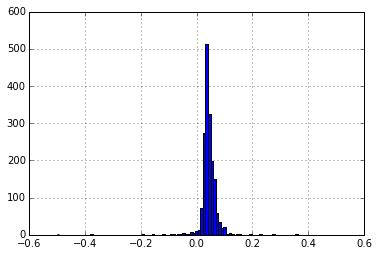

In [187]:
investor_fut_bucket_30360_xirr_orig.hist(bins=np.linspace(-.5,.5,110))

In [197]:
(investor_fut_bucket_30360_xirr_orig[investor_fut_bucket_30360_xirr_orig<0]*100).sort(inplace=False)

fk_user
10109     -37.459966
34054     -19.200474
10860     -15.587540
43106     -11.646885
18565      -9.395938
39596      -8.292229
1051       -6.674273
57196      -6.615652
10875      -6.033690
21689      -5.237668
21616      -5.237668
70380      -5.207702
34979      -4.757932
30313      -4.374064
27499      -4.374064
30250      -4.374064
23793      -4.374064
74370      -3.311351
73515      -3.185728
52551      -2.955957
25480      -2.583975
30245      -2.283771
138        -2.171029
20702      -1.932459
45815      -1.900109
75380      -1.867716
19633      -1.668579
6122       -1.646010
16137      -1.308895
55239      -0.931836
1835       -0.928396
23775      -0.903602
73709      -0.681998
73537      -0.378624
670        -0.031558
18621      -0.016670
dtype: float64

In [205]:
inv_count,inv_bin=np.histogram(investor_fut_bucket_30360_xirr_orig,bins=np.linspace(-.5,.5,101))


In [207]:
inv_hist=pd.DataFrame({'bin':inv_bin[:-1],'count':inv_count})

In [208]:
inv_hist.to_clipboard()

In [184]:
%matplotlib inline

In [175]:
loan_fundings1.head()

,dwh_country_id,id_loan_funding,fk_loan,fk_loan_request,fk_user,country_name,currency_code,loan_request_creation_date,amount,investment_yield,...,last_payment_date,irregular_payments,eur_amount,created_at,updated_at,dwh_created,dwh_last_modified,id_loan,principal_amount,loan_coverage1
0,1,165,9,20,1058,Germany,EUR,2013-12-01,50,3.1259,...,2015-04-23 11:26:34,NaN,50,2013-12-17 11:19:57,2015-04-23 11:26:35,2014-02-21 17:33:03.857077,2015-04-24 11:49:23.934222,9,10000,0.50
1,1,136,9,20,51,Germany,EUR,2013-12-01,25,3.1259,...,2015-04-23 14:20:32,NaN,25,2013-12-17 11:19:57,2015-04-23 14:20:32,2014-02-21 17:33:03.857077,2015-04-24 11:49:23.934222,9,10000,0.25
2,1,140,9,20,237,Germany,EUR,2013-12-01,400,3.1318,...,2015-04-23 13:53:54,NaN,400,2013-12-17 11:19:57,2015-04-23 13:53:55,2014-02-21 17:33:03.857077,2015-04-24 11:49:23.934222,9,10000,4.00
3,1,142,9,20,261,Germany,EUR,2013-12-01,50,3.1259,...,2015-04-23 11:40:35,NaN,50,2013-12-17 11:19:57,2015-04-23 11:40:36,2014-02-21 17:33:03.857077,2015-04-24 11:49:23.934222,9,10000,0.50
4,1,146,9,20,305,Germany,EUR,2013-12-01,25,3.1259,...,2015-04-23 11:41:59,NaN,25,2013-12-17 11:19:57,2015-04-23 11:42:00,2014-02-21 17:33:03.857077,2015-04-24 11:49:23.934222,9,10000,0.25


In [177]:
investor_cashflows_fut_bucket_30360=cashflows_fut_bucket_30360.merge(loan_fundings1[['fk_loan','fk_user','loan_coverage1']],left_on=['id_loan'],right_on='fk_loan')

In [214]:
investor_fut_bucket_30360_xirr_orig[investor_fut_bucket_30360_xirr_orig>.3]

fk_user
976        0.360354
2304       0.360354
17291      0.574551
17476      0.574551
dtype: float64

In [220]:
actual_payments[actual_payments.fk_loan==132]

,dwh_country_id,fk_user_borrower,fk_loan,loan_nr,iso_date,interval,interval_payback_date,payment_amount,payment_amount_cum,principal_amount,...,initial_principal_amount,residual_principal_amount,expected_amount_month,expected_amount_cum,actual_amount_month,actual_amount_cum,in_arrears_flag,in_arrears_since,in_arrears_since_days,in_arrears_since_days_30360
1475,1,17419,132,440274380,2014-06-30,0,2014-06-01,33.32,33.32,0.0000,...,7000.0000,7000.0000,33.32,33.32,34.83,34.83,0,NaN,NaN,NaN
1476,1,17419,132,440274380,2014-07-31,1,2014-07-01,141.24,174.56,95.7944,...,7000.0000,6904.2056,141.24,174.56,141.24,176.07,0,NaN,NaN,NaN
1477,1,17419,132,440274380,2014-08-31,2,2014-08-01,141.24,315.80,96.4202,...,6904.2056,6807.7854,141.24,315.80,141.24,317.31,0,NaN,NaN,NaN
1478,1,17419,132,440274380,2014-09-30,3,2014-09-01,141.24,457.04,97.0461,...,6807.7854,6710.7392,141.24,457.04,141.24,458.55,0,NaN,NaN,NaN
1479,1,17419,132,440274380,2014-10-31,4,2014-10-01,141.24,598.28,97.6761,...,6710.7392,6613.0631,141.24,598.28,141.24,599.79,0,NaN,NaN,NaN
1480,1,17419,132,440274380,2014-11-30,5,2014-11-01,141.24,739.52,98.3102,...,6613.0631,6514.7529,141.24,739.52,141.24,741.03,0,NaN,NaN,NaN
1481,1,17419,132,440274380,2014-12-31,6,2014-12-01,141.24,880.76,98.9484,...,6514.7529,6415.8045,141.24,880.76,141.24,882.27,0,NaN,NaN,NaN
1482,1,17419,132,440274380,2015-01-31,7,2015-01-01,141.24,1022.00,99.5907,...,6415.8045,6316.2138,141.24,1022.00,141.24,1023.51,0,NaN,NaN,NaN
1483,1,17419,132,440274380,2015-02-28,8,2015-02-01,141.24,1163.24,100.2372,...,6316.2138,6215.9765,141.24,1163.24,141.24,1164.75,0,NaN,NaN,NaN
1484,1,17419,132,440274380,2015-03-31,9,2015-03-01,141.24,1304.48,100.8880,...,6215.9765,6115.0886,141.24,1304.48,141.24,1305.99,0,NaN,NaN,NaN


In [215]:
a=investor_cashflows_fut_bucket_30360[investor_cashflows_fut_bucket_30360.fk_user==17291]
a.to_clipboard()
a

,id_loan,date,payment,dcf,rating_base,rating_switch,payback_state,fk_loan,fk_user,loan_coverage1,orig_payment
159261,132,2014-06-30,0.248786,0.753425,D,1,payback_pending,132,17291,0.714286,34.830000
159323,132,2014-07-31,1.008857,0.668493,D,1,payback_pending,132,17291,0.714286,141.240000
159385,132,2014-08-31,1.008857,0.583562,D,1,payback_pending,132,17291,0.714286,141.240000
159447,132,2014-09-30,1.008857,0.501370,D,1,payback_pending,132,17291,0.714286,141.240000
159509,132,2014-10-31,1.008857,0.416438,D,1,payback_pending,132,17291,0.714286,141.240000
159571,132,2014-11-30,1.008857,0.334247,D,1,payback_pending,132,17291,0.714286,141.240000
159633,132,2014-12-31,1.008857,0.249315,D,1,payback_pending,132,17291,0.714286,141.240000
159695,132,2015-01-31,1.008857,0.164384,D,1,payback_pending,132,17291,0.714286,141.240000
159757,132,2015-02-28,1.008857,0.087671,D,1,payback_pending,132,17291,0.714286,141.240000
159819,132,2015-03-31,1.008857,0.002740,D,1,payback_pending,132,17291,0.714286,141.240000


In [ ]:
investor_cashflows_fut_bucket_30360.

In [180]:
investor_cashflows_fut_bucket_30360['orig_payment']=investor_cashflows_fut_bucket_30360['payment']
investor_cashflows_fut_bucket_30360['payment']=investor_cashflows_fut_bucket_30360['orig_payment']*investor_cashflows_fut_bucket_30360['loan_coverage1']/100.0


In [154]:
loans_fut_bucket_30360_xirr_orig*100

rating_switch
1                2.446569
2                3.991386
3                3.453717
dtype: float64

In [165]:
loans_fut_bucket_30360_xirr_orig*100 

rating_switch
1                2.915440
2                4.099140
3                3.495064
dtype: float64

In [47]:
z1=cashflows_fut_bucket_30360[cashflows_fut_bucket_30360.payback_state!='payback_complete']

xirr(z1.payment, z1.dcf)

0.03470183916784976

In [42]:
loans_fut_bucket_30360_xirr_groups*100

rating_switch  rating_base
1              A              2.164635
               B             -0.289620
               C              2.843701
               D              4.380164
               E              7.495481
2              A              2.336687
               B              3.229219
               C              4.145394
               D              5.631069
               E              7.443198
3              A              2.390730
               B              2.876238
               C              3.830051
               D              4.275146
               E              4.906416
dtype: float64

In [43]:
loans_fut_bucket_30360_xirr_groups.to_clipboard()

In [308]:
loans_fut_bucket_30360_xirr_groups*100

rating_switch  rating_base
1              A              1.643829
               B             -0.131926
               C              2.983228
               D              4.437063
               E              7.266957
2              A              1.954274
               B              2.373271
               C              4.145764
               D              5.446206
               E              7.389547
3              A              2.368428
               B              2.950076
               C              3.790125
               D              3.940688
               E              4.880346
dtype: float64

In [167]:
loans_fut_xirr_groups=cashflows_fut[cashflows_fut.payback_state!='payback_complete'].groupby(['rating_switch','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))

In [246]:
loans_fut_xirr_groups*100

rating_switch  rating_base
1              A               2.318630
               B               2.276984
               C               3.590574
               D               5.797576
               E               7.664678
2              A               2.533089
               B               3.506267
               C               6.085838
               D               7.710767
               E               7.674173
3              A             -15.986781
               B             -15.818247
               C             -14.123845
               D             -11.749378
               E             -12.484912
dtype: float64

In [309]:
(loans_fut_bucket_xirr_groups*100)

rating_switch  rating_base
1              A              1.643829
               B             -0.131926
               C              2.983228
               D              4.437063
               E              7.266957
2              A              1.954274
               B              2.373271
               C              4.145764
               D              5.446206
               E              7.389547
3              A              2.368428
               B              2.950076
               C              3.790125
               D              3.940688
               E              4.880346
dtype: float64

In [168]:
loans_fut_bucket_xirr_groups=cashflows_fut_bucket_30360[cashflows_fut_bucket_30360.payback_state!='payback_complete'].groupby(['rating_switch','rating_base']).apply(lambda x: xirr(x.payment,x.dcf))
(loans_fut_bucket_xirr_groups*100)

rating_switch  rating_base
1              A              2.317944
               B             -0.195389
               C              3.016421
               D              8.264013
               E              7.614183
2              A              2.525294
               B              3.289584
               C              4.318376
               D              5.665452
               E              7.526119
3              A              2.410894
               B              2.911874
               C              3.853142
               D              4.340949
               E              5.067028
dtype: float64

In [154]:
loans_fut_xirr=pd.DataFrame(loans_fut_xirr,columns=['irr'])
loans_fut_xirr_pb=loans_fut_xirr.merge(loans[['id_loan','payback_state']],left_index=True,right_on='id_loan',how='left')
loans_fut_xirr_pb.set_index('id_loan', inplace=True)

In [153]:
loans_fut_xirr1.head()

,irr,id_loan,payback_state
6,0.051250,7,payback
0,0.025000,9,payback
8,0.052125,10,payback
4,0.023063,12,payback
3,0.027797,13,payback


In [89]:
loans_fut_xirr[loans_fut_xirr>.2]


id_loan
51          1.550209
65          2.082980
71          1.026548
92          0.913007
98          0.921890
232         2.715411
253         2.530222
270         3.796371
304         0.236168
334         5.211220
349         2.898589
354         4.808944
366         3.689217
498         6.032595
507         5.509628
625         0.961159
860        68.781251
dtype: float64

In [103]:
loans_fut_xirr[loans_fut_xirr<-.2]

id_loan
27        -0.871503
76        -0.959543
449       -0.470978
dtype: float64

In [136]:
(loans_fut_xirr[loans_fut_xirr<.2]*100).hist(bins=100)

In [121]:
loans.state.value_counts()

payback                    1669
payout_pending                8
payout_approval_pending       2
dtype: int64

In [96]:
payment_plans[payment_plans.fk_loan==65]

,dwh_country_id,fk_loan_payment_plan,fk_user,fk_loan_request,fk_loan,country_name,currency_code,loan_request_creation_date,interval,payment_amount,interest_amount,principal_amount,interval_payback_date,next_interval_payback_date,initial_principal_amount,sum_interval_interest_amount,residual_interest_amount,residual_principal_amount,eur_payment_amount,recovery
2067,1,63,5527,3533,65,Germany,EUR,2014-01-29,1,549.32,92.0000,457.3200,2014-04-01,2014-04-17,12000.0000,92.0000,517.9653,11542.6800,549.32,0.2613
2068,1,63,5527,3533,65,Germany,EUR,2014-01-29,2,0.00,0.0000,0.0000,2014-04-17,2014-05-15,11542.6800,92.0000,517.9653,11542.6800,0.00,0.2613
2069,1,63,5527,3533,65,Germany,EUR,2014-01-29,3,549.32,129.7910,419.5290,2014-05-15,2014-06-15,11542.6800,221.7910,388.1743,11123.1510,549.32,0.2613
2070,1,63,5527,3533,65,Germany,EUR,2014-01-29,4,549.32,85.2775,464.0425,2014-06-15,2014-07-15,11123.1510,307.0685,302.8968,10659.1085,549.32,0.2613
2071,1,63,5527,3533,65,Germany,EUR,2014-01-29,5,549.32,81.7198,467.6002,2014-07-15,2014-08-15,10659.1085,388.7883,221.1770,10191.5083,549.32,0.2613
2072,1,63,5527,3533,65,Germany,EUR,2014-01-29,6,549.32,78.1349,471.1851,2014-08-15,2014-09-15,10191.5083,466.9232,143.0421,9720.3232,549.32,0.2613
2073,1,63,5527,3533,65,Germany,EUR,2014-01-29,7,549.32,74.5225,474.7975,2014-09-15,2014-10-14,9720.3232,541.4457,68.5196,9245.5257,549.32,0.2613
2074,1,63,5527,3533,65,Germany,EUR,2014-01-29,8,9314.05,68.5196,9245.5257,2014-10-14,2199-01-01,9245.5257,609.9653,0.0000,0.0000,9314.05,0.2613


In [122]:
np.histogram(payment_plans.payment_amount,bins=[0,1,5,10,20,100,500,1000])

(array([   70,   328,   263,   504, 17098, 60279,  7554]),
 array([   0,    1,    5,   10,   20,  100,  500, 1000]))

In [127]:
np.histogram(payment_plans.payment_amount[payment_plans.interval==0],bins=[0,1,5,10,20,100,500,1000])

(array([ 69, 328, 263, 383, 705,  60,   0]),
 array([   0,    1,    5,   10,   20,  100,  500, 1000]))

In [126]:
payment_plans.interval[payment_plans.payment_amount<10].value_counts()

0    660
2      1
dtype: int64

In [112]:
cashflows_fut[cashflows_fut.id_loan==360].sort('date')

,id_loan,date,payment,dcf
60321,360,2014-08-28,-3000.00,0.591781
3121,360,2014-09-30,2.06,0.501370
3122,360,2014-10-31,3026.64,0.416438
3123,360,2014-11-30,0.00,0.334247
3124,360,2014-12-31,0.00,0.249315
3125,360,2015-01-31,-46.93,0.164384
3126,360,2015-02-28,0.00,0.087671
3127,360,2015-03-31,0.00,0.002740


In [113]:
actual_payments[actual_payments.fk_loan==360]

,dwh_country_id,fk_user_borrower,fk_loan,loan_nr,iso_date,interval,interval_payback_date,payment_amount,payment_amount_cum,principal_amount,...,principal_amount_cum,initial_principal_amount,residual_principal_amount,expected_amount_month,expected_amount_cum,actual_amount_month,actual_amount_cum,in_arrears_flag,in_arrears_since,in_arrears_since_days
3121,1,35161,360,470144237,2014-09-30,0,2014-09-01,2.06,2.06,0.000,...,0.000,3000.000,3000.000,2.06,2.06,2.06,2.06,0,None,NaN
3122,1,35161,360,470144237,2014-10-31,2,2014-10-10,2953.07,3028.70,2947.005,...,3000.000,2947.005,0.000,3026.64,3028.70,3026.64,3028.70,0,None,NaN
3123,1,35161,360,470144237,2014-11-30,2,2014-10-10,2953.07,3028.70,2947.005,...,3000.000,2947.005,0.000,0.00,3028.70,0.00,3028.70,0,None,NaN
3124,1,35161,360,470144237,2014-12-31,2,2014-10-10,2953.07,3028.70,2947.005,...,3000.000,2947.005,0.000,0.00,3028.70,0.00,3028.70,0,None,NaN
3125,1,35161,360,470144237,2015-01-31,1,2014-10-01,73.57,75.63,52.995,...,52.995,3000.000,2947.005,0.00,3028.70,-46.93,2981.77,1,2014-10-10,113
3126,1,35161,360,470144237,2015-02-28,1,2014-10-01,73.57,75.63,52.995,...,52.995,3000.000,2947.005,0.00,3028.70,0.00,2981.77,1,2014-10-10,141
3127,1,35161,360,470144237,2015-03-31,1,2014-10-01,73.57,75.63,52.995,...,52.995,3000.000,2947.005,0.00,3028.70,0.00,2981.77,1,2014-10-10,172


In [91]:
future_pd[future_pd.fk_loan==304].T

,9193,9194,9195,9196,9197,9198,9199,9200,9201
dwh_country_id,1,1,1,1,1,1,1,1,1
fk_loan_payment_plan,302,302,302,302,302,302,302,302,302
fk_user,29754,29754,29754,29754,29754,29754,29754,29754,29754
fk_loan_request,18589,18589,18589,18589,18589,18589,18589,18589,18589
fk_loan,304,304,304,304,304,304,304,304,304
country_name,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany,Germany
currency_code,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR,EUR
loan_request_creation_date,2014-07-23 00:00:00,2014-07-23 00:00:00,2014-07-23 00:00:00,2014-07-23 00:00:00,2014-07-23 00:00:00,2014-07-23 00:00:00,2014-07-23 00:00:00,2014-07-23 00:00:00,2014-07-23 00:00:00
interval,52,53,54,55,56,57,58,59,60
payment_amount,51.02,51.02,51.02,51.02,51.02,51.02,51.02,51.02,50.62


In [76]:
loans_fut_xirr.hist()

In [164]:
resid=payment_plans_idx.loc[idx[:,:,payment_plans_idx.index.get_level_values(2)<'2015-03-24']\
                        ,'residual_principal_amount'].groupby(level=(0,1)).nth(-1)
cashflows=payment_plans_idx.loc[idx[:,:,payment_plans_idx.index.get_level_values(2)<'2015-03-24'],'payment_amount']
cashflows1=cashflows.append([-loan_orig.principal_amount,resid])
cashflows2=pd.DataFrame(cashflows1)
cashflows2['dcf']=(np.datetime64('2015-03-24','D')-np.array(cashflows2.index.get_level_values(2).to_datetime(),dtype='datetime64[D]'))/np.timedelta64(1,'D')/365

In [255]:
cashflows=pd.DataFrame(payment_plans_pd.loc[~(payment_plans_pd.fk_loan.isin(miss_loans)),['fk_loan','interval_payback_date','e_tot']])
cashflows.interval_payback_date=np.array(cashflows.interval_payback_date,'datetime64[D]')
cashflows.e_tot*=(1-.01)
loans_orig=loans.loc[~(payment_plans_pd.fk_loan.isin(miss_loans)),['id_loan','originated_since','principal_amount']]
loans_orig.principal_amount=-loans_orig.principal_amount
loans_orig['originated_since_date']=np.array(loans_orig['originated_since'],'datetime64[D]')

cashflows1=cashflows.rename(columns={'fk_loan':'id_loan','interval_payback_date':'date','e_tot':'payment'})


In [169]:
cashflows.head()

,fk_loan,interval_payback_date,e_tot
0,7,2014-01-01,0.630000
1,7,2014-02-01,44.000624
2,7,2014-03-01,43.810256
3,7,2014-04-01,43.620712
4,7,2014-05-01,43.431988


In [256]:
principal_payments=loans_orig[['id_loan','originated_since_date' ,'principal_amount']].\
    rename(columns={'originated_since_date':'date' ,'principal_amount':'payment'})
cashflows2=cashflows1.append(principal_payments,ignore_index=True)
cashflows2["dcf"]=(np.datetime64('2015-03-24','D')  -cashflows2["date"].values)/np.timedelta64(1,'D')/365

In [257]:
cashflows2["dcf"]=(np.datetime64('2015-03-24','D')  -cashflows2["date"].values)/np.timedelta64(1,'D')/365

In [ ]:
cashflows2[cashflows2.id_loan==85]

In [258]:
cashflows2[cashflows2.id_loan==85]

,id_loan,date,payment,dcf
43329,966,2015-02-01,9.098100,0.139726
43330,966,2015-03-01,81.251575,0.063014
43331,966,2015-04-01,80.553800,-0.021918
43332,966,2015-05-01,79.860454,-0.104110
43333,966,2015-06-01,79.171508,-0.189041
43334,966,2015-07-01,78.486937,-0.271233
43335,966,2015-08-01,77.806712,-0.356164
43336,966,2015-09-01,77.130806,-0.441096
43337,966,2015-10-01,76.459193,-0.523288
43338,966,2015-11-01,75.791845,-0.608219


In [286]:
actual_payments[actual_payments.fk_loan==966]

,dwh_country_id,fk_user_borrower,fk_loan,loan_nr,iso_date,payment_amount,payment_amount_cum,principal_amount,interest_amount,sum_interval_interest_amount,...,principal_amount_cum,initial_principal_amount,residual_principal_amount,expected_amount_month,expected_amount_cum,actual_amount_month,actual_amount_cum,in_arrears_flag,in_arrears_since,in_arrears_since_days
5343,1,73957,966,140346852,2015-02-28,9.19,9.19,0.000,9.1867,9.1867,...,0.000,3000,3000.000,9.19,9.19,9.19,9.19,0,NaN,NaN
5344,1,73957,966,140346852,2015-03-31,71.69,80.88,54.465,17.2250,26.4117,...,54.465,3000,2945.535,71.69,80.88,71.69,80.88,0,NaN,NaN


In [186]:
xirr(cashflows2.loc[cashflows2.id_loan==500,'payment'],cashflows2.loc[cashflows2.id_loan==500,'dcf'])*100

5.4735134310179845

In [100]:
miss_loans=set(loans.id_loan) ^ set(payment_plans.fk_loan) # symmetric difference

In [259]:
loans_xirr=cashflows2.groupby('id_loan').apply(lambda x: xirr(x.payment,x.dcf))

In [215]:
mth3_loans=loans_orig.id_loan[loans_orig.originated_since_date<np.datetime64('2015-01-22')]

In [252]:
payment_plans_pd[payment_plans_pd.fk_loan==966].to_clipboard()

In [260]:

f=plt.figure(1)
f.clf()
(loans_xirr*100).hist()

In [207]:
loans[loans.id_loan==966].T

,991
dwh_country_id,1
id_loan,966
fk_loan_request,55818
fk_user,73957
fk_ranking,13143
country_name,Germany
currency_code,EUR
loan_request_creation_date,2015-01-07 00:00:00
user_age,55
loan_nr,140346852


In [251]:
(loans_xirr.loc[mth3_loans]*100).hist()

In [253]:
loans_xirr.loc[966]

0.03870272564140468

In [254]:
loans_orig[loans_orig.id_loan==966]

,id_loan,originated_since,principal_amount,originated_since_date
991,966,2015-01-15 15:27:19,-3000,2015-01-15


In [203]:
cashflows2[cashflows2.id_loan==966].sort('date').to_clipboard()

In [103]:
no0=set(payment_plans.fk_loan.unique()) - set( pp1.fk_loan.unique()) # checking if each loan has interval 0 
no0

{16,
 21,
 38,
 40,
 63,
 64,
 65,
 68,
 73,
 94,
 195,
 200,
 202,
 203,
 204,
 205,
 234,
 245,
 251,
 253,
 256,
 257,
 258,
 271,
 320,
 435,
 704,
 709,
 718,
 719,
 721,
 730,
 784,
 978,
 1502,
 1602,
 1618,
 1625,
 1628,
 1631,
 1645,
 1647,
 1654,
 1690,
 1703,
 1728,
 1730,
 1754,
 1756}

In [39]:
def xnpv(rs,amounts, taus):
    """ should work for scalars and vectors. 
    taus: is the day count fraction as of the valuation date (tau=0)
    """
    qs=np.power(1+rs ,taus)
    return np.sum(amounts*qs)

In [40]:
def xirr(amounts,taus, guess=0.1):
    # RuntimeError: Failed to converge after 50 iterations, value is nan
    try:
        z=scipy.optimize.newton(lambda r: xnpv(r,amounts, taus),guess)
    except RuntimeError:
        z=np.nan
    return z

In [107]:
loan_plan_nar=payment_plans_idx.loc[payment_plans_idx.interval!=0,['interest_amount','initial_principal_amount']].groupby(level=(0,1)).sum()